#70-74


In [2]:
cp /content/drive/MyDrive/field/knock60/GoogleNews-vectors-negative300.bin /content

In [1]:
import gdown

url = 'https://drive.google.com/uc?id=0B7XkCwpI5KDYNlNUTTlSS21pQmM'
output = 'data.bin.gz'

gdown.download(url, output, quiet=False)

Access denied with the following error:



 	Too many users have viewed or downloaded this file recently. Please
	try accessing the file again later. If the file you are trying to
	access is particularly large or is shared with many people, it may
	take up to 24 hours to be able to view or download the file. If you
	still can't access a file after 24 hours, contact your domain
	administrator. 

You may still be able to access the file from the browser:

	 https://drive.google.com/uc?id=0B7XkCwpI5KDYNlNUTTlSS21pQmM 



In [3]:
!ls

drive  GoogleNews-vectors-negative300.bin  sample_data


In [4]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00359/NewsAggregatorDataset.zip
!unzip NewsAggregatorDataset.zip

--2023-06-26 05:44:29--  https://archive.ics.uci.edu/ml/machine-learning-databases/00359/NewsAggregatorDataset.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘NewsAggregatorDataset.zip’

NewsAggregatorDatas     [     <=>            ]  27.87M  33.0MB/s    in 0.8s    

2023-06-26 05:44:30 (33.0 MB/s) - ‘NewsAggregatorDataset.zip’ saved [29224203]

Archive:  NewsAggregatorDataset.zip
  inflating: 2pageSessions.csv       
   creating: __MACOSX/
  inflating: __MACOSX/._2pageSessions.csv  
  inflating: newsCorpora.csv         
  inflating: __MACOSX/._newsCorpora.csv  
  inflating: readme.txt              
  inflating: __MACOSX/._readme.txt   


In [5]:
!sed -e 's/"/'\''/g' ./newsCorpora.csv > ./newsCorpora_re.csv

In [ ]:
ls

2pageSessions.csv  __MACOSX/                  newsCorpora_re.csv
data.bin           NewsAggregatorDataset.zip  readme.txt
drive/             newsCorpora.csv            sample_data/


In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split

# データの読込
df = pd.read_csv('./newsCorpora_re.csv', header=None, sep='\t', names=['ID', 'TITLE', 'URL', 'PUBLISHER', 'CATEGORY', 'STORY', 'HOSTNAME', 'TIMESTAMP'])

# データの抽出
df = df.loc[df['PUBLISHER'].isin(['Reuters', 'Huffington Post', 'Businessweek', 'Contactmusic.com', 'Daily Mail']), ['TITLE', 'CATEGORY']]

# データの分割
train, valid_test = train_test_split(df, test_size=0.2, shuffle=True, random_state=123, stratify=df['CATEGORY'])
valid, test = train_test_split(valid_test, test_size=0.5, shuffle=True, random_state=123, stratify=valid_test['CATEGORY'])

# 事例数の確認
print('【学習データ】')
print(train['CATEGORY'].value_counts())
print('【検証データ】')
print(valid['CATEGORY'].value_counts())
print('【評価データ】')
print(test['CATEGORY'].value_counts())

【学習データ】
b    4501
e    4235
t    1220
m     728
Name: CATEGORY, dtype: int64
【検証データ】
b    563
e    529
t    153
m     91
Name: CATEGORY, dtype: int64
【評価データ】
b    563
e    530
t    152
m     91
Name: CATEGORY, dtype: int64


In [7]:
import gdown
from gensim.models import KeyedVectors

model = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)

In [8]:
import string
import torch

def transform_w2v(text):
  table = str.maketrans(string.punctuation, ' '*len(string.punctuation))
  words = text.translate(table).split()  # 記号をスペースに置換後、スペースで分割してリスト化
  vec = [model[word] for word in words if word in model]  # 1語ずつベクトル化

  return torch.tensor(sum(vec) / len(vec))  # 平均ベクトルをTensor型に変換して出力

In [9]:
# 特徴ベクトルの作成
X_train = torch.stack([transform_w2v(text) for text in train['TITLE']])
X_valid = torch.stack([transform_w2v(text) for text in valid['TITLE']])
X_test = torch.stack([transform_w2v(text) for text in test['TITLE']])

print(X_train.size())
print(X_train)

torch.Size([10684, 300])
tensor([[ 0.0837,  0.0056,  0.0068,  ...,  0.0751,  0.0433, -0.0868],
        [ 0.0272,  0.0266, -0.0947,  ..., -0.1046, -0.0489, -0.0092],
        [ 0.0577, -0.0159, -0.0780,  ..., -0.0421,  0.1229,  0.0876],
        ...,
        [ 0.0392, -0.0052,  0.0686,  ..., -0.0175,  0.0061, -0.0224],
        [ 0.0798,  0.1017,  0.1066,  ..., -0.0752,  0.0623,  0.1138],
        [ 0.1664,  0.0451,  0.0508,  ..., -0.0531, -0.0183, -0.0039]])


In [10]:
# ラベルベクトルの作成
category_dict = {'b': 0, 't': 1, 'e':2, 'm':3}
y_train = torch.tensor(train['CATEGORY'].map(lambda x: category_dict[x]).values)
y_valid = torch.tensor(valid['CATEGORY'].map(lambda x: category_dict[x]).values)
y_test = torch.tensor(test['CATEGORY'].map(lambda x: category_dict[x]).values)

print(y_train.size())
print(y_train)

torch.Size([10684])
tensor([0, 1, 3,  ..., 0, 3, 2])


In [11]:
# 保存
torch.save(X_train, 'X_train.pt')
torch.save(X_valid, 'X_valid.pt')
torch.save(X_test, 'X_test.pt')
torch.save(y_train, 'y_train.pt')
torch.save(y_valid, 'y_valid.pt')
torch.save(y_test, 'y_test.pt')

In [12]:
from torch import nn

class SLPNet(nn.Module):
  def __init__(self, input_size, output_size):
    super().__init__()
    self.fc = nn.Linear(input_size, output_size, bias=False)
    nn.init.normal_(self.fc.weight, 0.0, 1.0)  # 正規乱数で重みを初期化

  def forward(self, x):
    x = self.fc(x)
    return x

In [13]:
model = SLPNet(300, 4)  # 単層ニューラルネットワークの初期化
y_hat_1 = torch.softmax(model(X_train[:1]), dim=-1)
print(y_hat_1)

tensor([[0.3556, 0.4048, 0.0285, 0.2111]], grad_fn=<SoftmaxBackward0>)


In [14]:
Y_hat = torch.softmax(model.forward(X_train[:4]), dim=-1)
print(Y_hat)

tensor([[0.3556, 0.4048, 0.0285, 0.2111],
        [0.0349, 0.7043, 0.0093, 0.2514],
        [0.1665, 0.2258, 0.0015, 0.6061],
        [0.7657, 0.0831, 0.0066, 0.1446]], grad_fn=<SoftmaxBackward0>)


In [15]:
criterion = nn.CrossEntropyLoss()

In [16]:
l_1 = criterion(model(X_train[:1]), y_train[:1])  # 入力ベクトルはsoftmax前の値
model.zero_grad()  # 勾配をゼロで初期化
l_1.backward()  # 勾配を計算
print(f'損失: {l_1:.4f}')
print(f'勾配:\n{model.fc.weight.grad}')

損失: 1.0340
勾配:
tensor([[-0.0539, -0.0036, -0.0044,  ..., -0.0484, -0.0279,  0.0559],
        [ 0.0339,  0.0023,  0.0028,  ...,  0.0304,  0.0175, -0.0351],
        [ 0.0024,  0.0002,  0.0002,  ...,  0.0021,  0.0012, -0.0025],
        [ 0.0177,  0.0012,  0.0014,  ...,  0.0159,  0.0091, -0.0183]])


In [17]:
l = criterion(model(X_train[:4]), y_train[:4])
model.zero_grad()
l.backward()
print(f'損失: {l:.4f}')
print(f'勾配:\n{model.fc.weight.grad}')

損失: 1.7277
勾配:
tensor([[-0.0215,  0.0082,  0.0067,  ..., -0.0174,  0.0052,  0.0136],
        [ 0.0086, -0.0013,  0.0046,  ...,  0.0127,  0.0157, -0.0036],
        [ 0.0145, -0.0122, -0.0156,  ...,  0.0037, -0.0094,  0.0045],
        [-0.0016,  0.0053,  0.0043,  ...,  0.0010, -0.0115, -0.0145]])


In [18]:
from torch.utils.data import Dataset

class NewsDataset(Dataset):
  def __init__(self, X, y):  # datasetの構成要素を指定
    self.X = X
    self.y = y

  def __len__(self):  # len(dataset)で返す値を指定
    return len(self.y)

  def __getitem__(self, idx):  # dataset[idx]で返す値を指定
    return [self.X[idx], self.y[idx]]

In [19]:
from torch.utils.data import DataLoader

# Datasetの作成
dataset_train = NewsDataset(X_train, y_train)
dataset_valid = NewsDataset(X_valid, y_valid)
dataset_test = NewsDataset(X_test, y_test)

# Dataloaderの作成
dataloader_train = DataLoader(dataset_train, batch_size=1, shuffle=True)
dataloader_valid = DataLoader(dataset_valid, batch_size=len(dataset_valid), shuffle=False)
dataloader_test = DataLoader(dataset_test, batch_size=len(dataset_test), shuffle=False)

In [20]:
# モデルの定義
model = SLPNet(300, 4)

# 損失関数の定義
criterion = nn.CrossEntropyLoss()

# オプティマイザの定義
optimizer = torch.optim.SGD(model.parameters(), lr=1e-1)

# 学習
num_epochs = 10
for epoch in range(num_epochs):
  # 訓練モードに設定
  model.train()
  loss_train = 0.0
  for i, (inputs, labels) in enumerate(dataloader_train):
    # 勾配をゼロで初期化
    optimizer.zero_grad()

    # 順伝播 + 誤差逆伝播 + 重み更新
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    # 損失を記録
    loss_train += loss.item()

  # バッチ単位の平均損失計算
  loss_train = loss_train / i

  # 検証データの損失計算
  model.eval()
  with torch.no_grad():
    inputs, labels = next(iter(dataloader_valid))
    outputs = model(inputs)
    loss_valid = criterion(outputs, labels)

  # ログを出力
  print(f'epoch: {epoch + 1}, loss_train: {loss_train:.4f}, loss_valid: {loss_valid:.4f}')

epoch: 1, loss_train: 0.4670, loss_valid: 0.3620
epoch: 2, loss_train: 0.3103, loss_valid: 0.3305
epoch: 3, loss_train: 0.2809, loss_valid: 0.3175
epoch: 4, loss_train: 0.2644, loss_valid: 0.3206
epoch: 5, loss_train: 0.2558, loss_valid: 0.3126
epoch: 6, loss_train: 0.2475, loss_valid: 0.3144
epoch: 7, loss_train: 0.2432, loss_valid: 0.3105
epoch: 8, loss_train: 0.2382, loss_valid: 0.3132
epoch: 9, loss_train: 0.2354, loss_valid: 0.3153
epoch: 10, loss_train: 0.2325, loss_valid: 0.3151


In [21]:
def calculate_accuracy(model, loader):
  model.eval()
  total = 0
  correct = 0
  with torch.no_grad():
    for inputs, labels in loader:
      outputs = model(inputs)
      pred = torch.argmax(outputs, dim=-1)
      total += len(inputs)
      correct += (pred == labels).sum().item()

  return correct / total

In [22]:
acc_train = calculate_accuracy(model, dataloader_train)
acc_test = calculate_accuracy(model, dataloader_test)
print(f'正解率（学習データ）：{acc_train:.3f}')
print(f'正解率（評価データ）：{acc_test:.3f}')

正解率（学習データ）：0.922
正解率（評価データ）：0.899


#75. 損失と正解率のプロット

In [23]:
#損失と正解率を返す関数を定義、モデル、損失関数、データを入力
def calculate_loss_and_accuracy(model, criterion, loader):
  model.eval()
  loss = 0.0
  total = 0
  correct = 0

  #勾配の計算を無効化.学習時には必要だが、テスト時には必要ない
  with torch.no_grad():

    for inputs, labels in loader:
      outputs = model(inputs)
      loss += criterion(outputs, labels).item()
      pred = torch.argmax(outputs, dim=-1)
      total += len(inputs)
      correct += (pred == labels).sum().item()

  return loss / len(loader), correct / total

In [27]:

model = SLPNet(300, 4)

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model.parameters(), lr=1e-1)

num_epochs = 10
log_train = []
log_valid = []

#学習
for epoch in range(num_epochs):

  model.train()
  for inputs, labels in dataloader_train:

    optimizer.zero_grad()

    outputs = model(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

  # 損失と正解率の算出
  loss_train, acc_train = calculate_loss_and_accuracy(model, criterion, dataloader_train)
  loss_valid, acc_valid = calculate_loss_and_accuracy(model, criterion, dataloader_valid)
  log_train.append([loss_train, acc_train])
  log_valid.append([loss_valid, acc_valid])

  # チェックポイントの保存（knock76）
  torch.save({'epoch': epoch, 'model_state_dict': model.state_dict(), 'optimizer_state_dict': optimizer.state_dict()}, f'checkpoint{epoch + 1}.pt')


  #出力
  print(f'epoch: {epoch + 1}, loss_train: {loss_train:.4f}, accuracy_train: {acc_train:.4f}, loss_valid: {loss_valid:.4f}, accuracy_valid: {acc_valid:.4f}')

epoch: 1, loss_train: 0.3240, accuracy_train: 0.8915, loss_valid: 0.3680, accuracy_valid: 0.8690
epoch: 2, loss_train: 0.2940, accuracy_train: 0.9030, loss_valid: 0.3396, accuracy_valid: 0.8855
epoch: 3, loss_train: 0.2655, accuracy_train: 0.9099, loss_valid: 0.3234, accuracy_valid: 0.8847
epoch: 4, loss_train: 0.2503, accuracy_train: 0.9180, loss_valid: 0.3126, accuracy_valid: 0.8930
epoch: 5, loss_train: 0.2448, accuracy_train: 0.9184, loss_valid: 0.3095, accuracy_valid: 0.8945
epoch: 6, loss_train: 0.2367, accuracy_train: 0.9227, loss_valid: 0.3067, accuracy_valid: 0.8952
epoch: 7, loss_train: 0.2345, accuracy_train: 0.9228, loss_valid: 0.3107, accuracy_valid: 0.8945
epoch: 8, loss_train: 0.2287, accuracy_train: 0.9253, loss_valid: 0.3061, accuracy_valid: 0.8937
epoch: 9, loss_train: 0.2255, accuracy_train: 0.9262, loss_valid: 0.3069, accuracy_valid: 0.8922
epoch: 10, loss_train: 0.2248, accuracy_train: 0.9258, loss_valid: 0.3077, accuracy_valid: 0.8915


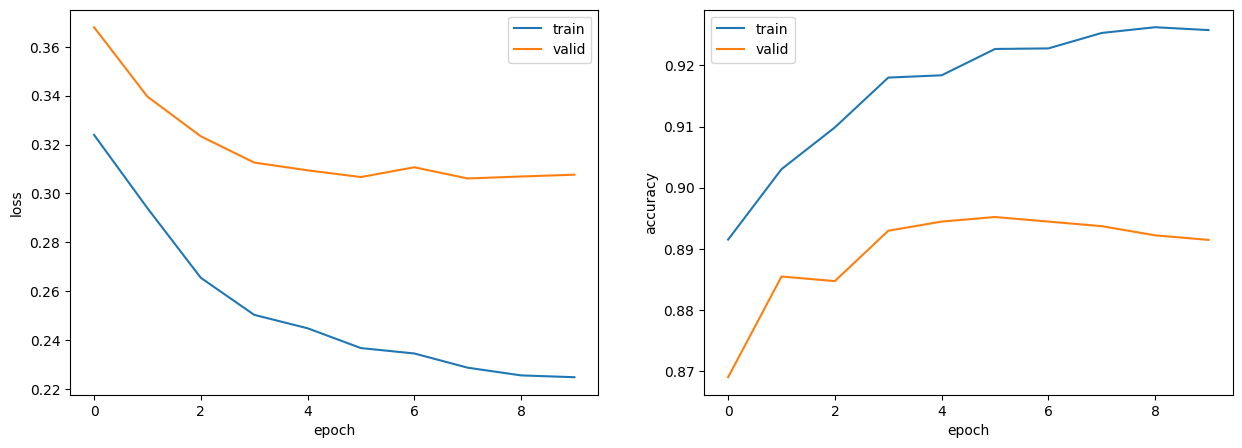

In [28]:
from matplotlib import pyplot as plt
import numpy as np

# 可視化
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(np.array(log_train).T[0], label='train')
ax[0].plot(np.array(log_valid).T[0], label='valid')
ax[0].set_xlabel('epoch')
ax[0].set_ylabel('loss')
ax[0].legend()
ax[1].plot(np.array(log_train).T[1], label='train')
ax[1].plot(np.array(log_valid).T[1], label='valid')
ax[1].set_xlabel('epoch')
ax[1].set_ylabel('accuracy')
ax[1].legend()
plt.show()

#76以下


In [32]:
import time

In [29]:
def calculate_loss_and_accuracy(model, criterion, loader, device):
  model.eval()
  loss = 0.0
  total = 0
  correct = 0
  with torch.no_grad():
    for inputs, labels in loader:
      inputs = inputs.to(device)
      labels = labels.to(device)
      outputs = model(inputs)
      loss += criterion(outputs, labels).item()
      pred = torch.argmax(outputs, dim=-1)
      total += len(inputs)
      correct += (pred == labels).sum().item()

  return loss / len(loader), correct / total


def train_model(dataset_train, dataset_valid, batch_size, model, criterion, optimizer, num_epochs, device=None):
  # GPUに送る
  model.to(device)

  # dataloaderの作成
  dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
  dataloader_valid = DataLoader(dataset_valid, batch_size=len(dataset_valid), shuffle=False)

  # 学習
  log_train = []
  log_valid = []
  for epoch in range(num_epochs):
    # 開始時刻の記録
    s_time = time.time()

    # 訓練モードに設定
    model.train()
    for inputs, labels in dataloader_train:
      # 勾配をゼロで初期化
      optimizer.zero_grad()

      # 順伝播 + 誤差逆伝播 + 重み更新
      inputs = inputs.to(device)
      labels = labels.to(device)
      outputs = model.forward(inputs)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()

    # 損失と正解率の算出
    loss_train, acc_train = calculate_loss_and_accuracy(model, criterion, dataloader_train, device)
    loss_valid, acc_valid = calculate_loss_and_accuracy(model, criterion, dataloader_valid, device)
    log_train.append([loss_train, acc_train])
    log_valid.append([loss_valid, acc_valid])

    # チェックポイントの保存
    torch.save({'epoch': epoch, 'model_state_dict': model.state_dict(), 'optimizer_state_dict': optimizer.state_dict()}, f'checkpoint{epoch + 1}.pt')

    # 終了時刻の記録
    e_time = time.time()

    # ログを出力
    print(f'epoch: {epoch + 1}, loss_train: {loss_train:.4f}, accuracy_train: {acc_train:.4f}, loss_valid: {loss_valid:.4f}, accuracy_valid: {acc_valid:.4f}, {(e_time - s_time):.4f}sec')

  return {'train': log_train, 'valid': log_valid}

In [33]:
# datasetの作成
dataset_train = NewsDataset(X_train, y_train)
dataset_valid = NewsDataset(X_valid, y_valid)

# モデルの定義
model = SLPNet(300, 4)

# 損失関数の定義
criterion = nn.CrossEntropyLoss()

# オプティマイザの定義
optimizer = torch.optim.SGD(model.parameters(), lr=1e-1)

# デバイスの指定
device = torch.device('cuda')

# モデルの学習
for batch_size in [2 ** i for i in range(11)]:
  print(f'バッチサイズ: {batch_size}')
  log = train_model(dataset_train, dataset_valid, batch_size, model, criterion, optimizer, 1, device=device)

バッチサイズ: 1
epoch: 1, loss_train: 0.3323, accuracy_train: 0.8847, loss_valid: 0.3606, accuracy_valid: 0.8757, 14.8563sec
バッチサイズ: 2
epoch: 1, loss_train: 0.3022, accuracy_train: 0.8946, loss_valid: 0.3386, accuracy_valid: 0.8825, 5.7954sec
バッチサイズ: 4
epoch: 1, loss_train: 0.2926, accuracy_train: 0.8974, loss_valid: 0.3324, accuracy_valid: 0.8832, 3.3870sec
バッチサイズ: 8
epoch: 1, loss_train: 0.2886, accuracy_train: 0.8991, loss_valid: 0.3299, accuracy_valid: 0.8847, 1.6595sec
バッチサイズ: 16
epoch: 1, loss_train: 0.2867, accuracy_train: 0.8992, loss_valid: 0.3285, accuracy_valid: 0.8840, 0.9088sec
バッチサイズ: 32
epoch: 1, loss_train: 0.2858, accuracy_train: 0.9005, loss_valid: 0.3281, accuracy_valid: 0.8847, 0.5318sec
バッチサイズ: 64
epoch: 1, loss_train: 0.2854, accuracy_train: 0.9003, loss_valid: 0.3278, accuracy_valid: 0.8840, 0.3241sec
バッチサイズ: 128
epoch: 1, loss_train: 0.2852, accuracy_train: 0.9005, loss_valid: 0.3276, accuracy_valid: 0.8840, 0.3566sec
バッチサイズ: 256
epoch: 1, loss_train: 0.2850, accuracy

#79


In [40]:
from torch.nn import functional as F
#多層ニューラルネットワークを定義
class MLPNet(nn.Module):
  #入力次元、中間層の次元、出力の次元（分類クラスの数）、中間層の数
  def __init__(self, input_size, mid_size, output_size, mid_layers):
    super().__init__()
    self.mid_layers = mid_layers
    self.fc = nn.Linear(input_size, mid_size)
    self.fc_mid = nn.Linear(mid_size, mid_size)
    self.fc_out = nn.Linear(mid_size, output_size)
    self.bn = nn.BatchNorm1d(mid_size)
#BN正規化とReLU関数の適用
  def forward(self, x):
    x = F.relu(self.fc(x))
    for _ in range(self.mid_layers):
      x = F.relu(self.bn(self.fc_mid(x)))
    x = F.relu(self.fc_out(x))

    return x

In [41]:
from torch import optim

#GPUを使うので、関数にdeviceが必要なため再定義
def calculate_loss_and_accuracy(model, criterion, loader, device):
  model.eval()
  loss = 0.0
  total = 0
  correct = 0
  with torch.no_grad():
    for inputs, labels in loader:
      inputs = inputs.to(device)
      labels = labels.to(device)
      outputs = model(inputs)
      loss += criterion(outputs, labels).item()
      pred = torch.argmax(outputs, dim=-1)
      total += len(inputs)
      correct += (pred == labels).sum().item()

  return loss / len(loader), correct / total


def train_model(dataset_train, dataset_valid, batch_size, model, criterion, optimizer, num_epochs, device=None):
  # GPUに送る
  model.to(device)

  # dataloaderの作成
  dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
  dataloader_valid = DataLoader(dataset_valid, batch_size=len(dataset_valid), shuffle=False)



  # 学習
  log_train = []
  log_valid = []
  for epoch in range(num_epochs):
    # 開始時刻の記録
    s_time = time.time()

    # 訓練モードに設定
    model.train()
    for inputs, labels in dataloader_train:
      # 勾配をゼロで初期化
      optimizer.zero_grad()

      # 順伝播 + 誤差逆伝播 + 重み更新
      inputs = inputs.to(device)
      labels = labels.to(device)
      outputs = model.forward(inputs)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()

    # 損失と正解率の算出
    loss_train, acc_train = calculate_loss_and_accuracy(model, criterion, dataloader_train, device)
    loss_valid, acc_valid = calculate_loss_and_accuracy(model, criterion, dataloader_valid, device)
    log_train.append([loss_train, acc_train])
    log_valid.append([loss_valid, acc_valid])

    # チェックポイントの保存
    torch.save({'epoch': epoch, 'model_state_dict': model.state_dict(), 'optimizer_state_dict': optimizer.state_dict()}, f'checkpoint{epoch + 1}.pt')

    # 終了時刻の記録
    e_time = time.time()

    # ログを出力
    print(f'epoch: {epoch + 1}, loss_train: {loss_train:.4f}, accuracy_train: {acc_train:.4f}, loss_valid: {loss_valid:.4f}, accuracy_valid: {acc_valid:.4f}, {(e_time - s_time):.4f}sec')

    # 検証データの損失が3エポック連続で低下しなかった場合は学習終了
    if epoch > 2 and log_valid[epoch - 3][0] <= log_valid[epoch - 2][0] <= log_valid[epoch - 1][0] <= log_valid[epoch][0]:
      break



  return {'train': log_train, 'valid': log_valid}

In [42]:

dataset_train = NewsDataset(X_train, y_train)
dataset_valid = NewsDataset(X_valid, y_valid)

model = MLPNet(300, 200, 4, 1)

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

device = torch.device('cuda')


log = train_model(dataset_train, dataset_valid, 64, model, criterion, optimizer, 1000, device)

epoch: 1, loss_train: 0.9168, accuracy_train: 0.7512, loss_valid: 0.9064, accuracy_valid: 0.7635, 0.5085sec
epoch: 2, loss_train: 0.7315, accuracy_train: 0.7693, loss_valid: 0.7245, accuracy_valid: 0.7769, 0.5029sec
epoch: 3, loss_train: 0.6623, accuracy_train: 0.7741, loss_valid: 0.6582, accuracy_valid: 0.7799, 0.5059sec
epoch: 4, loss_train: 0.6241, accuracy_train: 0.7779, loss_valid: 0.6223, accuracy_valid: 0.7829, 0.5063sec
epoch: 5, loss_train: 0.5986, accuracy_train: 0.7796, loss_valid: 0.5989, accuracy_valid: 0.7852, 0.4818sec
epoch: 6, loss_train: 0.5771, accuracy_train: 0.7834, loss_valid: 0.5794, accuracy_valid: 0.7882, 0.4988sec
epoch: 7, loss_train: 0.5588, accuracy_train: 0.7884, loss_valid: 0.5631, accuracy_valid: 0.7949, 0.4797sec
epoch: 8, loss_train: 0.5399, accuracy_train: 0.7972, loss_valid: 0.5466, accuracy_valid: 0.8016, 0.5048sec
epoch: 9, loss_train: 0.5242, accuracy_train: 0.8072, loss_valid: 0.5334, accuracy_valid: 0.8091, 0.5903sec
epoch: 10, loss_train: 0.508

In [44]:
def calculate_accuracy(model, loader, device):
  model.eval()
  total = 0
  correct = 0
  with torch.no_grad():
    for inputs, labels in loader:
      inputs = inputs.to(device)
      labels = labels.to(device)
      outputs = model(inputs)
      pred = torch.argmax(outputs, dim=-1)
      total += len(inputs)
      correct += (pred == labels).sum().item()

  return correct / total

In [46]:
# 正解率の確認
acc_train = calculate_accuracy(model, dataloader_train, device)
acc_test = calculate_accuracy(model, dataloader_test, device)
print(f'trasin ac:{acc_train:.3f}')
print(f'test ac:{acc_test:.3f}')

trasin ac:0.954
test ac:0.909
